# Pipelines

Автор - Алёшин Максим [@hairymax](https://yandex-students.slack.com/team/U02MM7BNHC6)

Примеры использования скриптов для автоматизации некоторых ds задач, которые реализовал в процессе работы над проектами.

Все функции задокументрованы, имеют описание параметров

In [1]:
# Все скрипты лежат в hmpipes.py
import hmpipes as hm

Предобработка и визуализация на примере датасета "Титаник" (источник - [Kaggle](https://www.kaggle.com/competitions/titanic/data))

In [2]:
import pandas as pd
import numpy as np

df_titanic_train = pd.read_csv('datasets/titanic_train.csv')
df_titanic_test = pd.read_csv('datasets/titanic_test.csv')

## Предобработка
### Информация о датафрейме

In [3]:
display(hm.dataframe_info(df_titanic_train))
hm.dataframe_info(df_titanic_test)

DataFrame shape  : 891 rows, 12 columns
Memory usage     : 0.08 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
PassengerId,891,100.00,int64
Survived,891,100.00,int64
Pclass,891,100.00,int64
Name,891,100.00,object
Sex,891,100.00,object
Age,714,80.13,float64
SibSp,891,100.00,int64
Parch,891,100.00,int64
Ticket,891,100.00,object
Fare,891,100.00,float64


DataFrame shape  : 418 rows, 11 columns
Memory usage     : 0.04 MB
Duplicates count : 0


,notNA,"notNA, %",dtype
PassengerId,418,100.00,int64
Pclass,418,100.00,int64
Name,418,100.00,object
Sex,418,100.00,object
Age,332,79.43,float64
SibSp,418,100.00,int64
Parch,418,100.00,int64
Ticket,418,100.00,object
Fare,417,99.76,float64
Cabin,91,21.77,object


### Заполнение пропусков в столбце аггрегирующей функцией
(по сгруппированным значениям другого столбца)

**Пример 1**. Заполнение lambda-функцией (здесь модой - самым встречаемым значением в группе)

In [4]:
df_tmp = hm.fillna_with_group_agg(df_titanic_train, 'Age', 'Sex', func=lambda x: pd.Series.mode(x)[0])
df_tmp['Age'].describe()

177 out of 177 values are filled with <function <lambda> at 0x000001A9B71DEAF0> of "Age" among "Sex"


count    891.000000
mean      27.871122
std       13.549541
min        0.420000
25%       19.000000
50%       24.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

**Пример 2**. Заполнение функцией `numpy`

In [5]:
df_tmp = hm.fillna_with_group_agg(df_titanic_train, 'Age', 'Sex', func=np.mean)
display(df_tmp['Age'].describe())

df_tmp = hm.fillna_with_group_agg(df_titanic_train, 'Age', 'Sex', func='first')
df_tmp['Age'].describe()


177 out of 177 values are filled with <function mean at 0x000001A9B1F4A310> of "Age" among "Sex"


count    891.000000
mean      29.736034
std       13.014897
min        0.420000
25%       22.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

177 out of 177 values are filled with first of "Age" among "Sex"


count    891.000000
mean      29.121403
std       13.456609
min        0.420000
25%       22.000000
50%       27.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

## Визуализация данных

### Количество значений

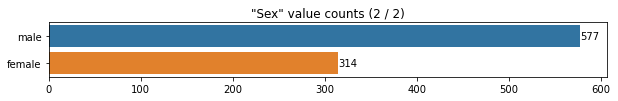

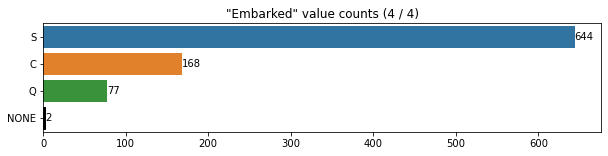

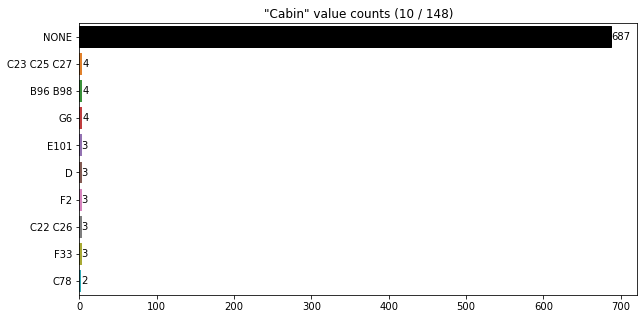

In [6]:
hm.plot_value_counts(df_titanic_train['Sex'])
hm.plot_value_counts(df_titanic_train['Embarked'])
hm.plot_value_counts(df_titanic_train['Cabin'], n_values=10)

### Гистограммы и диаграммы размаха

**Примеры** 
- для столбца из одного датасета
- для столбца из двух разных датасетов

Можно передать более 2х столбцов (pd.Series), также это могут быть разные столбцы

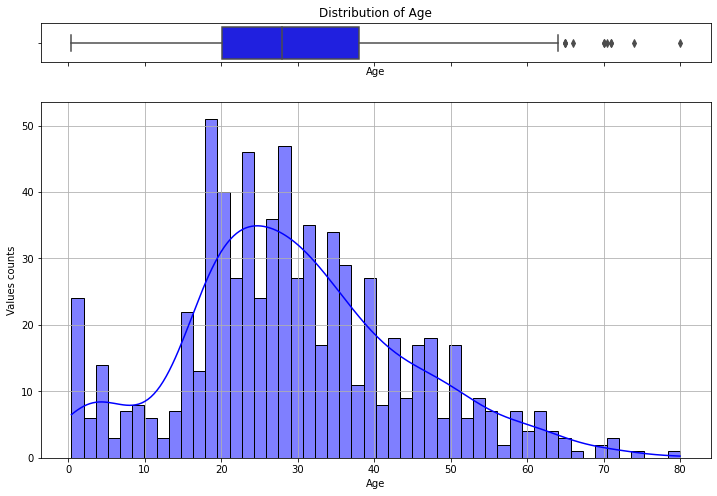

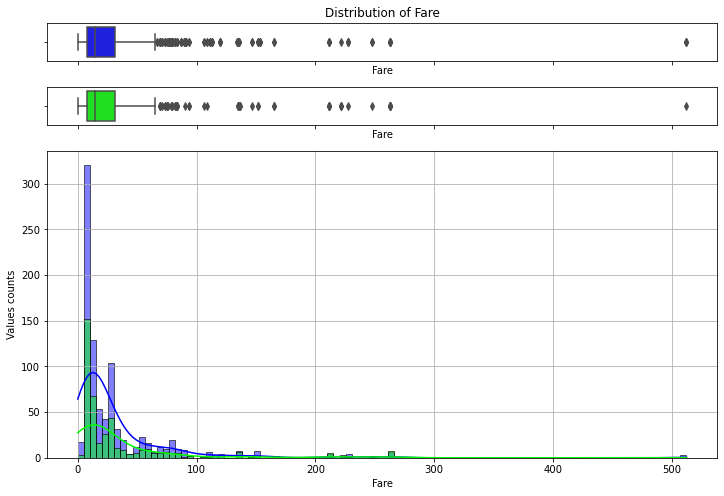

In [7]:
hm.plot_hist_and_box([df_titanic_train['Age']], bins=50)
hm.plot_hist_and_box([df_titanic_train['Fare'], df_titanic_test['Fare']])

### Диаграммы размаха для величин с разным диапазоном

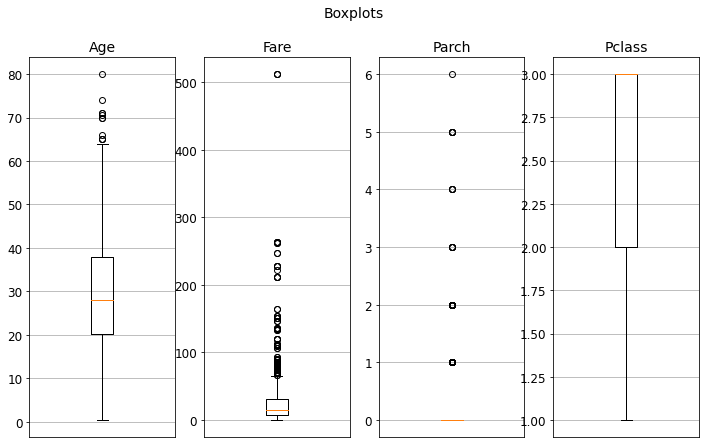

In [8]:
hm.boxplots(df_titanic_train, ['Age', 'Fare', 'Parch', 'Pclass'])

## Визуализация временных рядов

Функции в этом разделе принимают на вход `pd.Series`, у которой индекс имеет тип `DateTimeIndex`

На примере временного ряда ежедневных минимальных температур в городе Мельбурн в Австралии [датасет](https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv)

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_temperatures = pd.read_csv(
    'datasets/daily-min-temperatures.csv', index_col=[0], parse_dates=[0])
df_temperatures = df_temperatures.resample('1D').min()
t = df_temperatures['Temp']

### График временного ряда со скользящим средним и стандартным отклонением

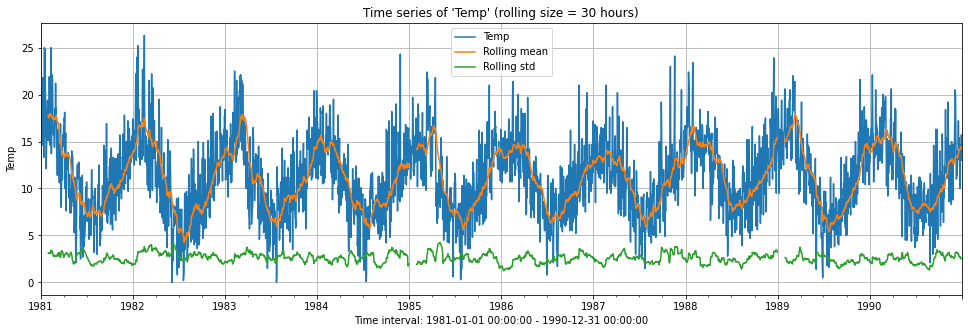

In [10]:
hm.plot_time_series(df_temperatures['Temp'], roll_size=30)

### Сезонность, тренд остатки

Более удобный интерфейс, можно указать только необходимые компоненты. см. описание функции

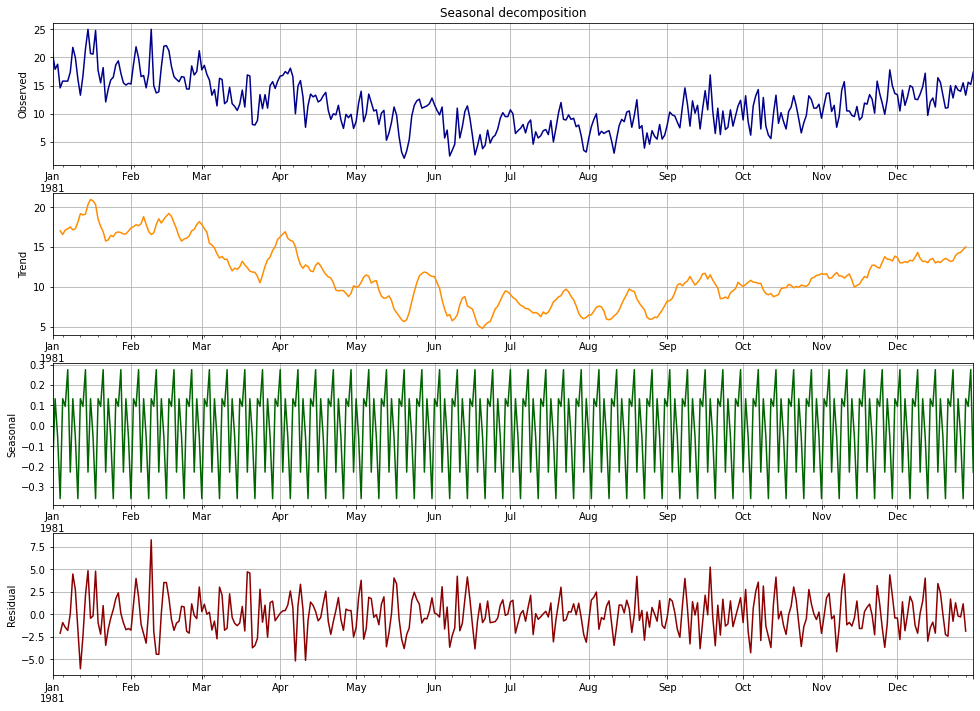

In [11]:
hm.plot_seasonal_decompose(seasonal_decompose(t['1981-01-01':'1981-12-31']), 'otsr')

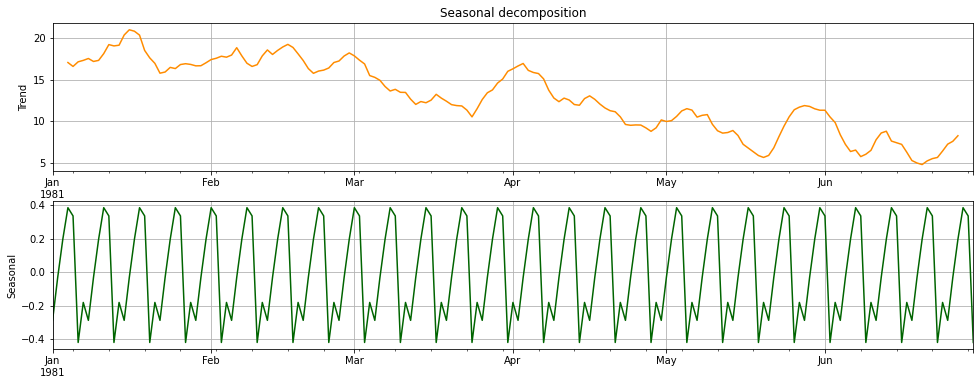

In [12]:
hm.plot_seasonal_decompose(seasonal_decompose(t['1981-01-01':'1981-06-30']), 'ts')


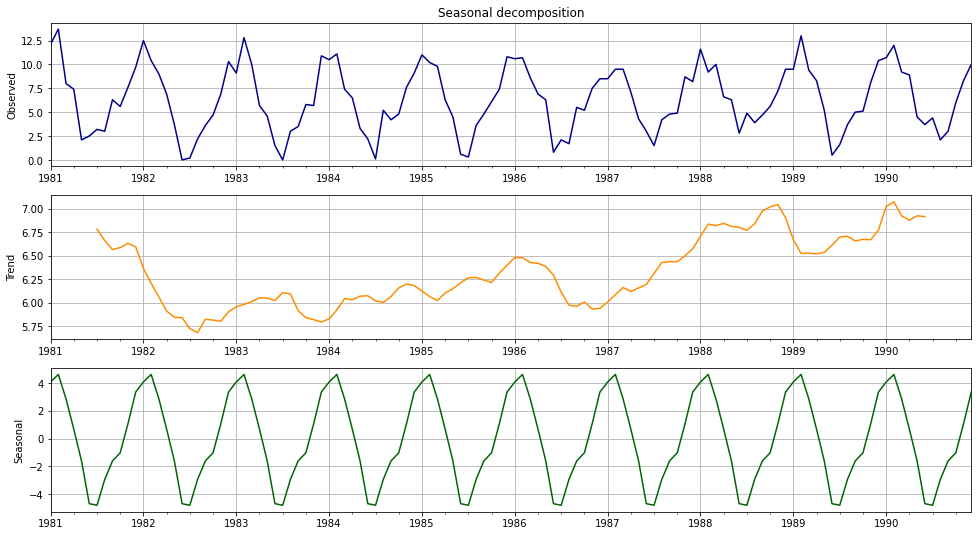

In [13]:
hm.plot_seasonal_decompose(seasonal_decompose(t.resample('1M').min()), 'ots')

### Усреднённые зависимости по периоду

Возможно указать период, поддерживаемый в `DateTimeIndex` библиотеки `pandas`.

**Примеры**: годовое среднее и месячное среднее

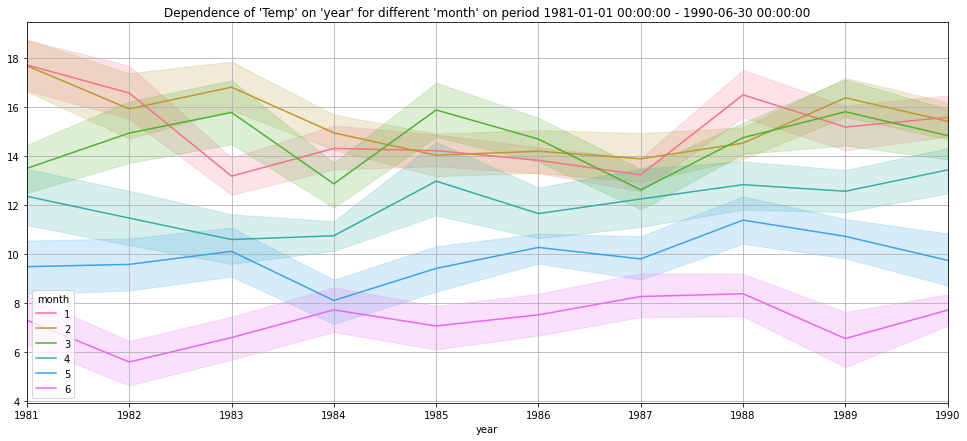

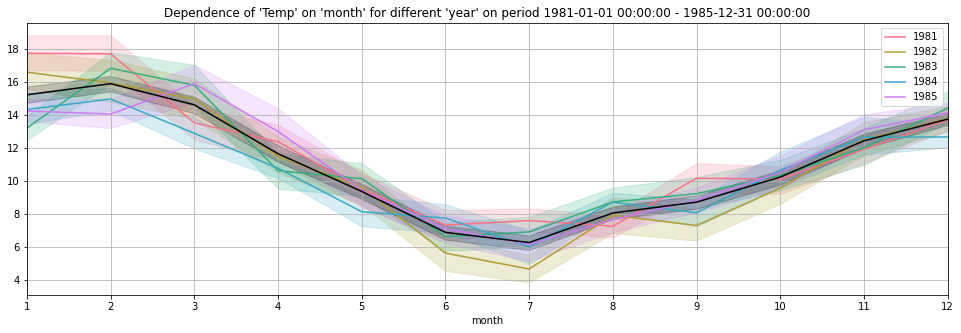

In [14]:
# годовое среднее в первые 6 месяцев каждого года
t_series = t[(t.index.month > 0) & (t.index.month <= 6)]
hm.plot_average_by_period(t_series, 'year', hue='month', figsize=(16.5,7))

# месячное среднее за годы с 1981 по 1985
hm.plot_average_by_period(t['1981-01-01':'1985-12-31'], 'month', hue='year', tot=True)


**Пример**: среднее за одно и то же число месяца по всем годам месячное среднее

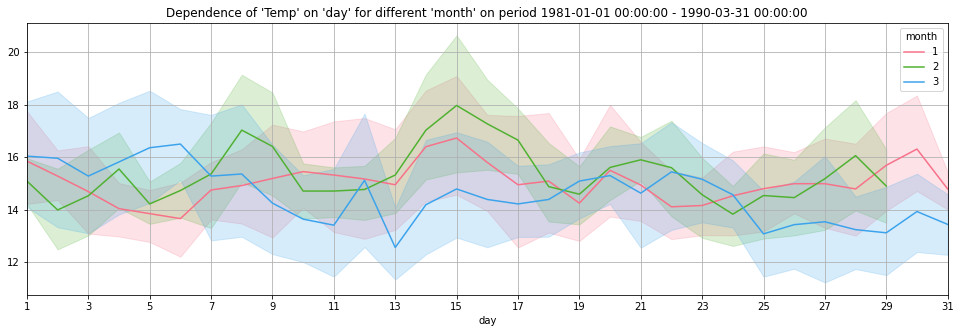

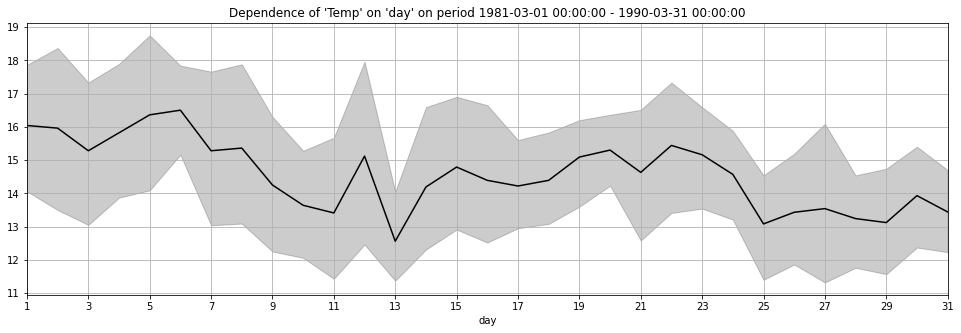

In [15]:
# за разные месяцы (с параметром hue)
t_series = t[(t.index.month > 0) & (t.index.month <= 3)]
hm.plot_average_by_period(t_series, 'day', hue='month', xstep=2)

# только третий тесяц, передаём срез, но без параметра hue
hm.plot_average_by_period(t[t.index.month == 3], 'day', xstep=2)


## Обучение моделей

Пример на датасете больных раком из scikit-learn

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dataset = load_breast_cancer()

### Топ параметров модели на кросс-валидации

In [17]:
%%time
params = {'max_depth': range(1, 11),
          'criterion': ['gini', 'entropy'],
          'random_state': [0, 1, 42, 123]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params,
                    n_jobs=-1, return_train_score=True)
grid.fit(dataset.data, dataset.target)

# В функцию передаём результат кросс-валидации
hm.best_cv_models(grid, 10)

Estimator: DecisionTreeClassifier()
Tested 80 models. Splits: None
Best score = 0.9420121099208197

CPU times: total: 328 ms
Wall time: 2.33 s


,test score,train score,"fit time, s","score time, s",criterion,max_depth,random_state
0,0.942012,0.984620,0.008799,0.000400,entropy,4,42
1,0.940258,0.984620,0.008400,0.000200,entropy,4,0
2,0.940258,0.994728,0.009400,0.000000,entropy,5,123
3,0.940258,0.984620,0.008400,0.000601,entropy,4,123
4,0.936749,0.999560,0.011401,0.000599,entropy,6,42
5,0.936749,1.000000,0.008799,0.000800,entropy,10,42
6,0.936749,1.000000,0.008599,0.000600,entropy,8,42
7,0.936749,1.000000,0.009798,0.000200,entropy,7,42
8,0.936749,1.000000,0.008399,0.000600,entropy,9,42
9,0.934995,1.000000,0.009199,0.000601,entropy,7,0


### Тестирование модели

fit и predict с измерением времени

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target)

hm.test_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test, 
              score_func=accuracy_score)

{'score test': 0.9440559440559441,
 'fit time': 0.003997325897216797,
 'predict time': 0.0,
 'predictions': array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1])}